In [88]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy.matlib as matlib
from scipy.stats import multivariate_normal
import numpy as np

'''
Notes for ML1003:

This is support code provided for the Bayesian Regression Problems.
The goal of this problem is to have you explore Bayesian Regression,
as described in Lectur 11.b slides 13-25.

A few things to note about this code:
    - We strongly encourage you to review this support code prior to
      completing "problem.py"
    - For Problem (b), you are asked to generate plots for three
      values of sigma_squared. We suggest you savid the plot generated
      by make_plots (instead of simply calling plt.show)
'''

# Notes from intial author (prior to some)
# translating the implementation at
# https://github.com/probml/pmtk3/blob/master/demos/bayesLinRegDemo2d.m
# into python
#
# Bayesian inference for simple linear regression with known noise variance
# The goal is to reproduce fig 3.7 from Bishop's book
# We fit the linear model f(x,w) = w0 + w1 x and plot the posterior over w.
# This file is from pmtk3.googlecode.com
# Given the mean = priorMu and covarianceMatrix = priorSigma of a prior
# Gaussian distribution over regression parameters; observed data, xtrain
# and ytrain; and the likelihood precision, generate the posterior
# distribution, postW via Bayesian updating and return the updated values
# for mu and sigma. xtrain is a design matrix whose first column is the all
# ones vector.

def generateData(dataSize, noiseParams, actual_weights):
    # x1: from [0,1) to [-1,1)
    x1 = -1 + 2 * np.random.rand(dataSize, 1)
    # appending the bias term
    xtrain = np.matrix(np.c_[np.ones((dataSize, 1)), x1])
    # random noise
    noise = np.matrix(np.random.normal(
                            noiseParams["mean"],
                            noiseParams["var"],
                            (dataSize, 1)))

    ytrain = (xtrain * actual_weights) + noise

    return xtrain, ytrain

def make_plots(actual_weights, xtrain, ytrain, likelihood_var, prior, likelihoodFunc, getPosteriorParams, getPredictiveParams):

    # #setup for plotting
    #
    showProgressTillDataRows = [1, 2, 10, -1]
    numRows = 1 + len(showProgressTillDataRows)
    numCols = 4
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=.8, wspace=.8)

    plotWithoutSeeingData(prior, numRows, numCols)

    # see data for as many rounds as specified and plot
    for roundNum, rowNum in enumerate(showProgressTillDataRows):
        current_row = roundNum + 1
        first_column_pos = (current_row * numCols) + 1

        # #plot likelihood on latest point
        plt.subplot(numRows, numCols, first_column_pos)


        likelihoodFunc_with_data = lambda W: likelihoodFunc(W,
                                                      xtrain[:rowNum,],
                                                      ytrain[:rowNum],
                                                      likelihood_var)
        contourPlot(likelihoodFunc_with_data, actual_weights)

        # plot updated posterior on points seen till now
        x_seen = xtrain[:rowNum]
        y_seen = ytrain[:rowNum]
        mu, cov = getPosteriorParams(x_seen, y_seen,
                                      prior, likelihood_var)
        posteriorDistr = multivariate_normal(mu.T.tolist()[0], cov)
        posteriorFunc = lambda x: posteriorDistr.pdf(x)
        plt.subplot(numRows, numCols, first_column_pos + 1)
        contourPlot(posteriorFunc, actual_weights)

        # plot lines
        dataSeen = np.c_[x_seen[:, 1], y_seen]
        plt.subplot(numRows, numCols, first_column_pos + 2)
        plotSampleLines(mu, cov, dataPoints=dataSeen)

        # plot predictive
        plt.subplot(numRows, numCols, first_column_pos + 3)
        postMean, postVar = getPosteriorParams(x_seen, y_seen, prior)
        plotPredictiveDistribution(getPredictiveParams, postMean, postVar)

    # #show the final plot
    plt.savefig("1.png")

def plotWithoutSeeingData(prior, numRows, numCols):

    #Blank likelihood
    plt.subplot(numRows, numCols, 1, axisbg='grey')
    plt.title("Likelihood")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-0.9, 0.9])
    plt.ylim([-0.9, 0.9])

    #Prior
    priorDistribution = multivariate_normal(mean=prior["mean"].T.tolist()[0],
        cov=prior["var"])
    priorFunc = lambda x:priorDistribution.pdf(x)
    plt.subplot(numRows, numCols, 2)
    plt.title("Prior/Posterior")
    contourPlot(priorFunc)

    # Plot initially valid lines (no data seen)
    plt.subplot(numRows, numCols, 3)
    plt.title("Data Space")
    plotSampleLines(prior["mean"], prior["var"])

    # Blank predictive
    plt.subplot(numRows, numCols, 4, axisbg='grey')
    plt.title('Predictive Distribution')
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("")
    plt.ylabel("")

def contourPlot(distributionFunc, actualWeights=[]):

    stepSize = 0.05
    array = np.arange(-1, 1, stepSize)
    x, y_train = np.meshgrid(array, array)

    length = x.shape[0] * x.shape[1]
    x_flat = x.reshape((length, 1))
    y_flat = y_train.reshape((length, 1))
    contourPoints = np.c_[x_flat, y_flat]

    values = map(distributionFunc, contourPoints)
    values = np.array(values).reshape(x.shape)

    plt.contourf(x, y_train, values)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.xticks([-0.5, 0, 0.5])
    plt.yticks([-0.5, 0, 0.5])
    plt.xlim([-0.9, 0.9])
    plt.ylim([-0.9, 0.9])

    if(len(actualWeights) == 2):
        plt.plot(float(actualWeights[0]), float(actualWeights[1]),
                 "*k", ms=5)

# Plot the specified number of lines of the form y_train = w0 + w1*x in [-1,1]x[-1,1] by
# drawing w0, w1 from a bivariate normal distribution with specified values
# for mu = mean and sigma = covariance Matrix. Also plot the data points as
# circles.
def plotSampleLines(mean, variance,
                    numberOfLines=6,
                    dataPoints=np.empty((0, 0))):
    stepSize = 0.05
    # generate and plot lines
    for round in range(1, numberOfLines):
        weights = np.matrix(np.random.multivariate_normal(mean.T.tolist()[0], variance)).T
        x1 = np.arange(-1, 1, stepSize)
        x = np.matrix(np.c_[np.ones((len(x1), 1)), x1])
        y_train = x * weights

        plt.plot(x1, y_train)

    # markings
    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("x")
    plt.ylabel("y")

    # plot data points if given
    if(dataPoints.size):
        plt.plot(dataPoints[:, 0], dataPoints[:, 1],
                 "co")

def plotPredictiveDistribution(getPredictiveParams,postMean, postVar):
    stepSize = 0.05
    x = np.arange(-1, 1, stepSize)
    x = np.matrix(np.c_[np.ones((len(x), 1)), x])
    predMeans = np.zeros(x.shape[0])
    predStds = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        predMeans[i], predStds[i] = getPredictiveParams(x[i,].T,
                                                        postMean,
                                                        postVar)
    predStds = np.sqrt(predStds)
    plt.plot(x[:,1], predMeans, 'b')
    plt.plot(x[:,1], predMeans + predStds, 'b--')
    plt.plot(x[:,1], predMeans - predStds, 'b--')
    plt.xticks([-1, 0, 1])
    plt.yticks([-0.5, 0, 0.5])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("x")
    plt.ylabel("y")


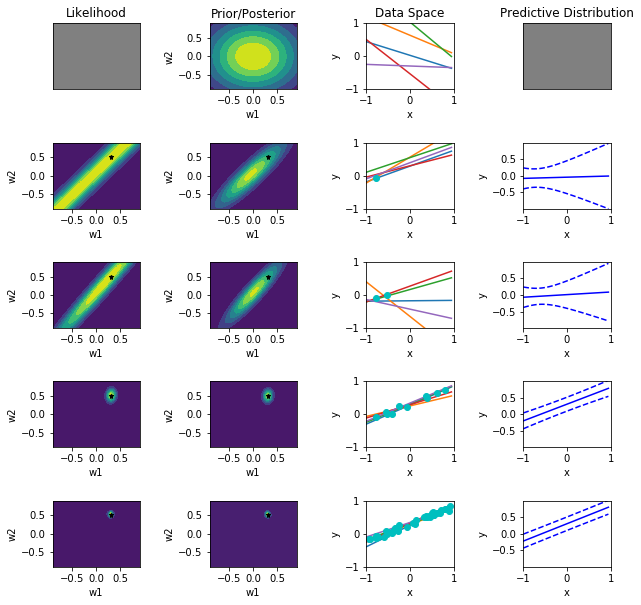

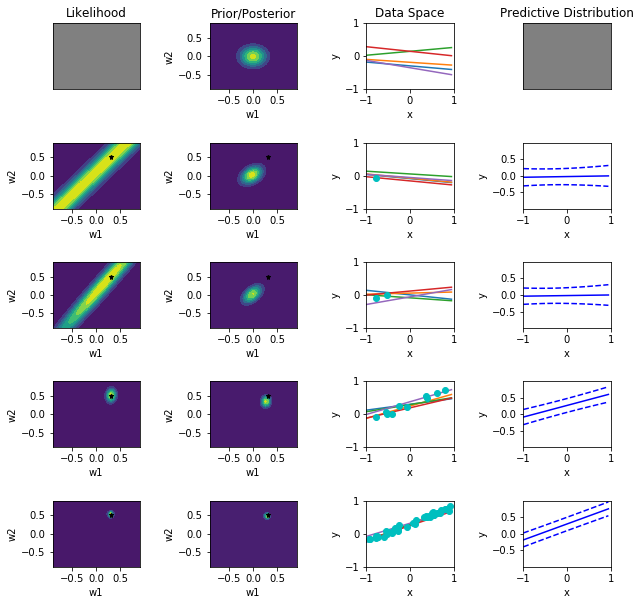

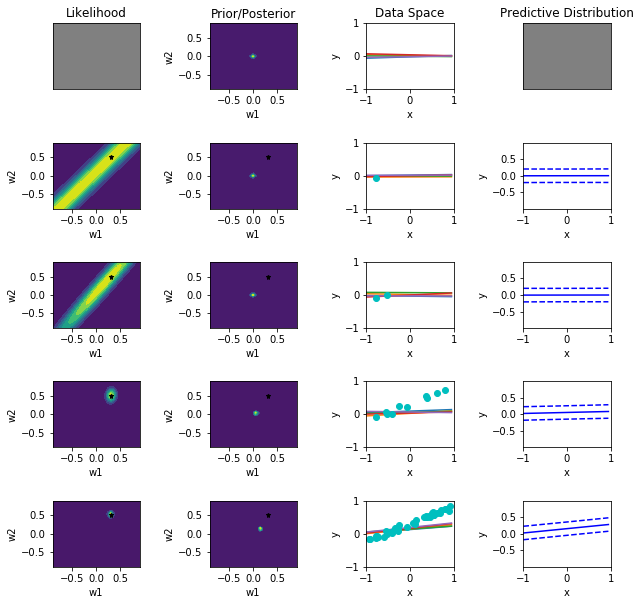

In [89]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy.matlib as matlib
from scipy.stats import multivariate_normal
import numpy as np
import support_code

def likelihoodFunc(W, x, y_train, likelihood_var):
    '''
    Implement likelihoodFunc. This function returns the data likelihood
    given f(y_train | x; W) ~ Normal(w^Tx, likelihood_var).

    Args:
        W: Weights
        x: Training design matrix with first col all ones (np.matrix)
        y_train: Training response vector (np.matrix)
        likelihood_var: likelihood variance

    Returns:
        likelihood: Data likelihood (float)
    '''

    #TO DO
    likelihood = 1
    for idx,row in enumerate(x):
        const = 1.0/np.sqrt(2*np.pi*likelihood_var)
        square_loss = np.square(y_train[idx] - np.dot(row,W.T))
        likelihood*= const*np.exp(-1*(square_loss/(2*likelihood_var)))
    return likelihood

def getPosteriorParams(x, y_train, prior, likelihood_var = 0.2**2):
    '''
    Implement getPosterioParams. This function returns the posterior
    mean vector \mu_p and posterior covariance matrix \Sigma_p for
    Bayesian regression (normal likelihood and prior).

    Note support_code.make_plots takes this completed function as an argument.

    Args:
        x: Training design matrix with first col all ones (np.matrix)
        y_train: Training response vector (np.matrix)
        prior: Prior parameters; dict with 'mean' (prior mean np.matrix)
               and 'var' (prior covariance np.matrix)
        likelihood_var: likelihood variance- default (0.2**2) per the lecture slides

    Returns:
        postMean: Posterior mean (np.matrix)
        postVar: Posterior mean (np.matrix)
    '''

    # TO DO
    #temp = np.dot(np.getI(np.dot(x.T,x) + likelihood_var*np.getI(prior['var'])),x.T)
    postMean = np.dot(np.dot(np.matrix.getI(np.dot(x.T,x) + likelihood_var*np.matrix.getI(prior['var'])),x.T),y_train)
    postVar = np.matrix.getI(np.dot(x.T,x)/likelihood_var + np.matrix.getI(prior['var']))
    return postMean, postVar

def getPredictiveParams(x_new, postMean, postVar, likelihood_var = 0.2**2):
    '''
    Implement getPredictiveParams. This function returns the predictive
    distribution parameters (mean and variance) given the posterior mean
    and covariance matrix (returned from getPosteriorParams) and the
    likelihood variance (default value from lecture).

    Args:
        x: New observation (np.matrix object)
        postMean, postVar: Returned from getPosteriorParams
        likelihood_var: likelihood variance (0.2**2) per the lecture slides

    Returns:
        - predMean: Mean of predictive distribution
        - predVar: Variance of predictive distribution
    '''

    # TO DO
    predMean = np.dot(postMean.T, x_new)
    predVar = np.dot(np.dot(x_new.T,postVar),x_new) + likelihood_var
    return predMean, predVar

if __name__ == '__main__':

    '''
    If your implementations are correct, running
        python problem.py
    inside the Bayesian Regression directory will, for each sigma in sigmas_to-test generates plots
    '''

    np.random.seed(46134)
    actual_weights = np.matrix([[0.3], [0.5]])
    dataSize = 40
    noise = {"mean":0, "var":0.2 ** 2}
    likelihood_var = noise["var"]
    xtrain, ytrain = support_code.generateData(dataSize, noise, actual_weights)

    #Question (b)
    sigmas_to_test = [1/2, 1/(2**5), 1/(2**10)]
    for sigma_squared in sigmas_to_test:
        prior = {"mean":np.matrix([[0], [0]]),
                 "var":matlib.eye(2) * sigma_squared}

        support_code.make_plots(actual_weights,
                                xtrain,
                                ytrain,
                                likelihood_var,
                                prior,
                                likelihoodFunc,
                                getPosteriorParams,
                                getPredictiveParams)


5.5:  
Effect of Sample Size and Strength of prior on :  
Likelihood function - Likelihood of data increases as the sample size increases and decreases as the strength of prior increases.  
Posterior Distribution - Posterior Distribution bias towards prior decreases as sample size increases as we have more data available and as the strength of prior increases the bias in the posterior towards prior increases.  
Posterior Predictive Distribution - Posterior predictive distribution is biased towards prior when the sample size is small and the prior strong, that is has lower variance. Bias decreases as the sample size increaases.

### 4.2.3

In [90]:
import scipy.optimize as optimize
from scipy.special import betaln

# Data
data  = [(50, 10000),(160, 20000),(180, 60000),(0, 100),(0,5),(1,2)]
def likelihood(params):
    a =  params[0]
    b = params[1]
    res=1
    for row in data:
        x_i  = row[0]
        n_i = row[1]
        res+= (betaln(a+x_i, b+n_i-x_i)-betaln(a,b))
    return -res

result = optimize.minimize(likelihood, [0.5,0.5], method = 'Nelder-Mead')
print "Optimal X:"
print '(', result.x[0], result.x[1],')'

Optimal X:
( 6.4689568203 1181.43551414 )


### 4.2.4

In [91]:
# App level posterior:
from scipy.stats import beta
a = 6.46895682
b = 1181.43551414
def get_posterior_params(x,n):
    beta_a = a + x
    beta_b = b + n - x
    mode = (beta_a - 1)/(beta_a + beta_b -2)
    mean, var = beta.stats(beta_a, beta_b)
    print mode, ' ', mean,' ', np.sqrt(var)

print 'MAP\t\t   Posterior Mean\tPosteriorSD'
get_posterior_params(50, 10000)
get_posterior_params(160, 20000)
get_posterior_params(180, 60000)
get_posterior_params(0, 100)
get_posterior_params(0, 5)
get_posterior_params(1, 2)

MAP		   Posterior Mean	PosteriorSD
0.00495882625889   0.00504732204021   0.000669943129109
0.00781033243338   0.00785679192806   0.000606534566292
0.00303123666184   0.00304748068155   0.000222828829712
0.00425300396997   0.00502285454074   0.00196911684853
0.00459227163333   0.00542286241479   0.00212543946186
0.00544568774522   0.00627693819318   0.00228859079971
